# Test A/A/B de Tipografía en App
## Paso 1: Cargar los datos y realizar inspección inicial

In [ ]:
# Paso 1.1: Cargar los datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

# Cargar archivo CSV separado por tabulaciones
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

#Mostrar detalles de Dataset
df.info()

# Mostrar las primeras filas
df.head()

ModuleNotFoundError: No module named 'statsmodels'

<div class="alert alert-block alert-success">
<b>Celda [1]</b> <a class="tocSkip"></a><br>
Has comenzado bien al cargar los datos y examinar su estructura inicial con `df.info()` y `df.head()`. Esto es crucial para entender las características del conjunto de datos, como el número de entradas y el tipo de cada columna, lo que te permitirá planificar mejor los siguientes pasos en tu análisis.
</div>


## Paso 2: Preparación de los datos

Renombramos las columnas para que tengan nombres más descriptivos:
- `event`: tipo de evento realizado
- `user_id`: identificador único de usuario
- `timestamp`: marca temporal en formato UNIX
- `experiment`: ID del experimento (246 y 247 = control, 248 = prueba)

También convertimos el timestamp a formato de fecha legible y separamos la fecha en una columna aparte.


In [ ]:
# Paso 2.1: Renombrar columnas para facilitar su manejo
df.columns = ['event', 'user_id', 'timestamp', 'experiment']

# Paso 2.2: Convertir timestamp a formato datetime legible
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Paso 2.3: Extraer solo la fecha (sin hora)
df['date'] = df['datetime'].dt.date

# Verificar las primeras filas después de la transformación
df.head()


,event,user_id,timestamp,experiment,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<div class="alert alert-block alert-success">
<b>Celda [2]</b> <a class="tocSkip"></a><br>
Has hecho un buen trabajo al renombrar las columnas y convertir los timestamps a un formato legible. 
</div>


## Paso 3: Exploración general de los datos

In [ ]:
# Paso 3.1: Eventos totales
total_eventos = len(df)

# Paso 3.2: Usuarios únicos
usuarios_unicos = df['user_id'].nunique()

# Paso 3.3: Promedio de eventos por usuario
eventos_por_usuario = total_eventos / usuarios_unicos

# Paso 3.4: Rango de fechas
fecha_min = df['datetime'].min()
fecha_max = df['datetime'].max()

# Resultados
print(f"Eventos totales: {total_eventos}")
print(f"Usuarios únicos: {usuarios_unicos}")
print(f"Promedio de eventos por usuario: {eventos_por_usuario:.2f}")
print(f"Rango de fechas: {fecha_min.date()} a {fecha_max.date()}")


Eventos totales: 244126
Usuarios únicos: 7551
Promedio de eventos por usuario: 32.33
Rango de fechas: 2019-07-25 a 2019-08-07


<div class="alert alert-block alert-success">
<b>Celda [3]</b> <a class="tocSkip"></a><br>
Has calculado correctamente las métricas básicas del conjunto de datos, como el número total de eventos, usuarios únicos y el promedio de eventos por usuario. Además, el rango de fechas te proporciona un contexto temporal útil para entender el periodo cubierto por los datos, lo que es esencial para cualquier análisis temporal posterior.
</div>


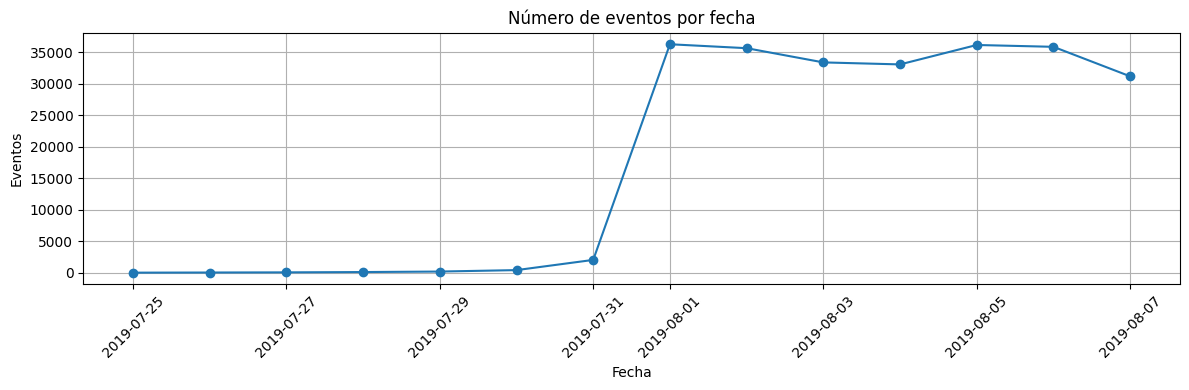

In [ ]:
# Paso 3.5: Histograma de eventos por fecha

# Agrupar eventos por fecha
eventos_por_fecha = df['date'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(12, 4))
plt.plot(eventos_por_fecha.index, eventos_por_fecha.values, marker='o')
plt.xticks(rotation=45)
plt.title('Número de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Eventos')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Paso 3.6: Filtrar datos a partir del 1 de agosto de 2019
fecha_inicio_confiable = pd.to_datetime("2019-08-01").date()
df_filtrado = df[df['date'] >= fecha_inicio_confiable]

# Comparar número de eventos y usuarios antes y después
eventos_antes = len(df)
usuarios_antes = df['user_id'].nunique()

eventos_despues = len(df_filtrado)
usuarios_despues = df_filtrado['user_id'].nunique()

eventos_excluidos = eventos_antes - eventos_despues
usuarios_excluidos = usuarios_antes - usuarios_despues

print(f"Eventos antes del filtrado: {eventos_antes}")
print(f"Eventos después del filtrado: {eventos_despues}")
print(f"Eventos excluidos: {eventos_excluidos}\n")

print(f"Usuarios antes del filtrado: {usuarios_antes}")
print(f"Usuarios después del filtrado: {usuarios_despues}")
print(f"Usuarios excluidos: {usuarios_excluidos}")


Eventos antes del filtrado: 244126
Eventos después del filtrado: 241298
Eventos excluidos: 2828

Usuarios antes del filtrado: 7551
Usuarios después del filtrado: 7534
Usuarios excluidos: 17


<div class="alert alert-block alert-success">
<b>Celda [5]</b> <a class="tocSkip"></a><br>
Has realizado un filtrado efectivo de los datos para enfocarte en el periodo más confiable. Comparar los números de eventos y usuarios antes y después del filtrado es crucial para entender cómo este proceso afecta tu análisis y asegurar que estás trabajando con datos relevantes.
</div>


In [ ]:
# Paso 3.7: Verificar presencia de los grupos experimentales tras el filtrado
grupos_presentes = df_filtrado['experiment'].value_counts().sort_index()

print("Distribución de usuarios por grupo experimental (después del filtrado):")
print(grupos_presentes)


Distribución de usuarios por grupo experimental (después del filtrado):
246    79425
247    77147
248    84726
Name: experiment, dtype: int64


<div class="alert alert-block alert-warning">
<b>Celda [6]</b> <a class="tocSkip"></a><br>
Verificar la presencia de los grupos experimentales tras el filtrado es un paso importante. Para asegurar que las comparaciones entre grupos sean válidas, sería beneficioso verificar también la distribución de usuarios entre los grupos. Esto se puede hacer con:
<pre><code>df_filtrado['experiment'].value_counts(normalize=True)</code></pre>
Esto te permitirá confirmar si los grupos están equilibrados en términos de proporción de usuarios, lo cual es crucial para la validez de tus análisis comparativos.
</div>


**Completitud de los datos**

Al analizar el histograma de eventos por fecha, se observa un cambio brusco a partir del ***1 de agosto de 2019***, donde el volumen de eventos supera los 10,000 diarios de forma consistente. Esto indica que los datos antes de esta fecha podrían estar incompletos o corresponder a pruebas.

**Por lo tanto, se considera como punto de partida confiable el 1 de agosto de 2019.**

**Impacto del filtrado**

Al excluir los registros anteriores al 1 de agosto:

- Eventos excluidos: 2,828
- Usuarios excluidos: 17

La pérdida es mínima en relación al total, por lo que se justifica su eliminación para asegurar la calidad del análisis.

**Verificación de grupos experimentales**

Tras filtrar los datos, confirmamos que están presentes los tres grupos experimentales:

- Grupo 246 (Control A)
- Grupo 247 (Control A)
- Grupo 248 (Prueba B)

Esto garantiza que el análisis del embudo de eventos y el test A/A/B puede continuar sin sesgos por datos incompletos.


## Paso 4: Embudo de eventos

In [ ]:
# Paso 4.1: Contar eventos únicos por frecuencia
eventos_frecuencia = df_filtrado['event'].value_counts()

# Mostrar los eventos ordenados
eventos_frecuencia


MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

<div class="alert alert-block alert-success">
<b>Celda [7]</b> <a class="tocSkip"></a><br>
Has identificado correctamente los eventos más frecuentes en los datos filtrados, lo cual es esencial para priorizar qué interacciones analizar más a fondo y para estructurar un embudo de conversión que refleje las acciones más comunes de los usuarios.
</div>


In [ ]:
# Paso 4.2: Número de usuarios únicos por cada evento
usuarios_por_evento = df_filtrado.groupby('event')['user_id'].nunique().sort_values(ascending=False)

# Proporción de usuarios que realizaron cada evento al menos una vez
usuarios_totales = df_filtrado['user_id'].nunique()
proporcion_usuarios_evento = (usuarios_por_evento / usuarios_totales).round(3)

# Combinar en una tabla
embudo_raw = pd.DataFrame({
    'usuarios_unicos': usuarios_por_evento,
    'proporcion': proporcion_usuarios_evento
})

embudo_raw


,usuarios_unicos,proporcion
event,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


<div class="alert alert-block alert-warning">
<b>Celda [8]</b> <a class="tocSkip"></a><br>
El cálculo de la proporción de usuarios únicos por evento es un buen paso para entender el embudo de conversión. Para mejorar la interpretación, considera visualizar estas proporciones, lo que facilitará la identificación de las etapas donde se produce la mayor caída en la conversión.
</div>


In [ ]:
# Paso 4.3: Definir orden lógico del embudo (basado en los nombres de eventos)
orden_eventos = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Extraer usuarios únicos por evento en orden definido
embudo_etapas = df_filtrado[df_filtrado['event'].isin(orden_eventos)]
usuarios_por_etapa = embudo_etapas.groupby('event')['user_id'].nunique().reindex(orden_eventos)

# Calcular conversión entre etapas
conversiones = usuarios_por_etapa / usuarios_por_etapa.shift(1)

# Crear tabla final del embudo
embudo = pd.DataFrame({
    'usuarios': usuarios_por_etapa,
    'conversion_vs_anterior': conversiones.round(3)
})

embudo


,usuarios,conversion_vs_anterior
event,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,0.619
CartScreenAppear,3734,0.813
PaymentScreenSuccessful,3539,0.948


<div class="alert alert-block alert-success">
<b>Celda [9]</b> <a class="tocSkip"></a><br>
Has estructurado correctamente el embudo de conversión y calculado las conversiones entre etapas. Este análisis es crucial para identificar las etapas del proceso donde se produce la mayor caída en la conversión, lo cual puede guiar estrategias para mejorar la retención de usuarios.
</div>


Basándonos en los nombres de los eventos, se propone el siguiente orden secuencial:

1. `MainScreenAppear` – pantalla principal
2. `OffersScreenAppear` – usuario navega por ofertas
3. `CartScreenAppear` – el usuario entra al carrito
4. `PaymentScreenSuccessful` – pago exitoso

Se calcula cuántos usuarios llegan a cada etapa y la conversión entre cada paso. Esto permite identificar en qué momento se pierden más usuarios.



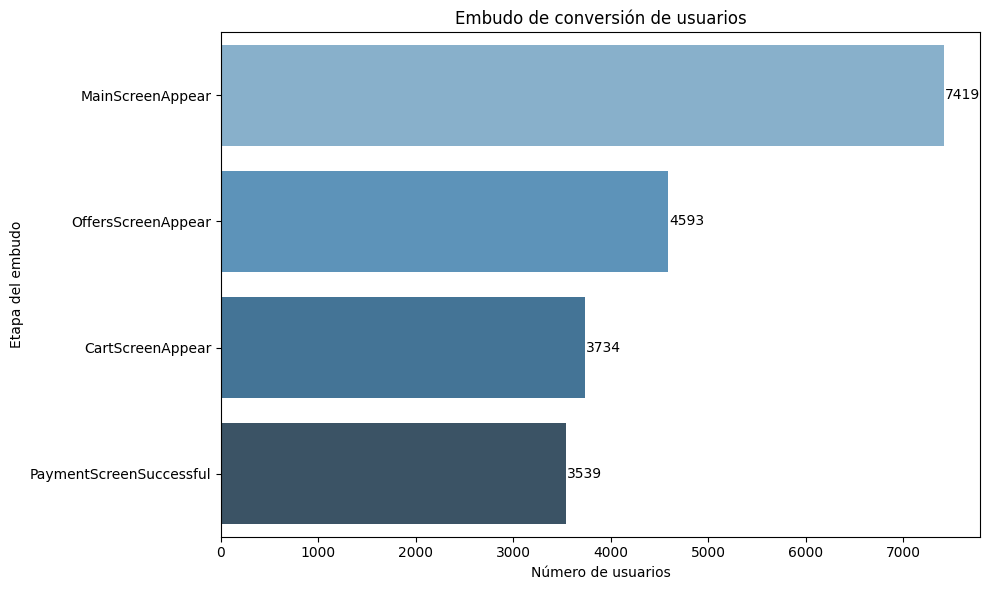

In [ ]:
# Paso 4.4: Visualizar el embudo de conversión

# Preparar datos
etapas = embudo.index
valores = embudo['usuarios']

# Crear gráfico de embudo
plt.figure(figsize=(10, 6))
sns.barplot(x=valores.values, y=etapas, orient='h', palette='Blues_d')

# Añadir etiquetas de cantidad
for i, v in enumerate(valores):
    plt.text(v + 10, i, str(v), va='center')

plt.title('Embudo de conversión de usuarios')
plt.xlabel('Número de usuarios')
plt.ylabel('Etapa del embudo')
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
<b>Celda [10]</b> <a class="tocSkip"></a><br>
El gráfico del embudo de conversión está bien diseñado y es claro. Para facilitar la comprensión de las tasas de conversión entre etapas, podrías añadir etiquetas que indiquen las tasas de conversión directamente en cada barra del gráfico.
</div>


In [ ]:
# Definir orden lógico de eventos en el embudo
orden_eventos = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Filtrar eventos del embudo
embudo_etapas = df_filtrado[df_filtrado['event'].isin(orden_eventos)]

# Calcular usuarios únicos por etapa
usuarios_por_etapa = embudo_etapas.groupby('event')['user_id'].nunique().reindex(orden_eventos)

# Calcular métricas del embudo
conversion_entre_etapas = usuarios_por_etapa / usuarios_por_etapa.shift(1)
proporcion_relativa = usuarios_por_etapa / usuarios_por_etapa.iloc[0]
caida_vs_anterior = 1 - conversion_entre_etapas

# Crear DataFrame del embudo
tabla_embudo = pd.DataFrame({
    'usuarios': usuarios_por_etapa,
    'conversion_vs_anterior': conversion_entre_etapas.round(3),
    'proporcion_relativa': proporcion_relativa.round(3),
    'caida_vs_anterior': caida_vs_anterior.round(3)
})

# Mostrar tabla
tabla_embudo.reset_index().rename(columns={'event': 'Etapa'})


,Etapa,usuarios,conversion_vs_anterior,proporcion_relativa,caida_vs_anterior
0,MainScreenAppear,7419,NaN,1.000,NaN
1,OffersScreenAppear,4593,0.619,0.619,0.381
2,CartScreenAppear,3734,0.813,0.503,0.187
3,PaymentScreenSuccessful,3539,0.948,0.477,0.052


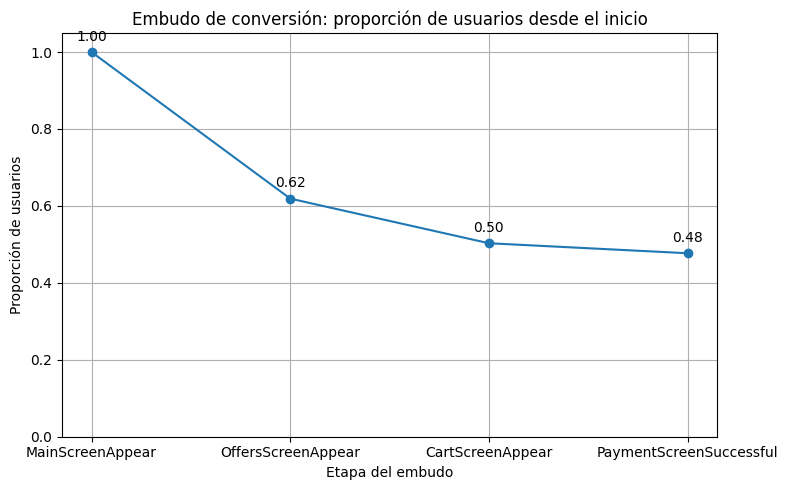

In [ ]:
# Gráfico de líneas: proporción relativa de usuarios por etapa
plt.figure(figsize=(8, 5))
plt.plot(tabla_embudo.index, tabla_embudo['proporcion_relativa'], marker='o', linestyle='-')

# Estética y etiquetas
plt.title('Embudo de conversión: proporción de usuarios desde el inicio')
plt.ylabel('Proporción de usuarios')
plt.xlabel('Etapa del embudo')
plt.ylim(0, 1.05)

# Etiquetas sobre los puntos
for i, valor in enumerate(tabla_embudo['proporcion_relativa']):
    plt.text(i, valor + 0.03, f'{valor:.2f}', ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()


**Análisis del embudo de conversión**

A partir del embudo de eventos calculado, obtenemos las siguientes proporciones entre etapas:

| Etapa                    | Usuarios | Conversión desde anterior | Conversión desde inicio | Caída desde anterior |
|--------------------------|----------|----------------------------|--------------------------|----------------------|
| MainScreenAppear         | 7,419    | -                          | 100%                     | -                    |
| OffersScreenAppear       | 4,593    | 61.9%                      | 61.9%                    | **38.1%**            |
| CartScreenAppear         | 3,734    | 81.3%                      | 50.3%                    | 18.7%                |
| PaymentScreenSuccessful  | 3,539    | 94.8%                      | **47.7%**                | 5.2%                 |

- **Mayor caída**: ocurre al pasar de `MainScreenAppear` a `OffersScreenAppear` con una pérdida del **38.1%**.
- **Usuarios que completan todo el embudo**: **47.7%** desde la primera pantalla hasta el pago exitoso.



## Paso 5. Estudiar los resultados del experimento

In [ ]:
# Paso 5.1: Usuarios únicos por grupo experimental (datos filtrados)
usuarios_por_grupo = df_filtrado.groupby('experiment')['user_id'].nunique()

usuarios_por_grupo


experiment
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [ ]:
# Paso 5.2: Evento más popular en los datos filtrados
evento_principal = df_filtrado['event'].value_counts().idxmax()
print(f"Evento más frecuente: {evento_principal}")

# Calcular proporción de usuarios que realizaron ese evento en cada grupo
def proporcion_evento_por_grupo(evento):
    df_evento = df_filtrado[df_filtrado['event'] == evento]
    usuarios_evento = df_evento.groupby('experiment')['user_id'].nunique()
    total_usuarios = df_filtrado.groupby('experiment')['user_id'].nunique()
    return (usuarios_evento / total_usuarios).fillna(0).round(4)

proporcion_evento_por_grupo(evento_principal)


Evento más frecuente: MainScreenAppear


experiment
246    0.9863
247    0.9853
248    0.9827
Name: user_id, dtype: float64

In [ ]:
# Paso 5.3: Función para comparar proporciones entre dos grupos
def prueba_z_entre_grupos(evento, grupo_a=246, grupo_b=247):
    # Total de usuarios por grupo
    total_a = df_filtrado[df_filtrado['experiment'] == grupo_a]['user_id'].nunique()
    total_b = df_filtrado[df_filtrado['experiment'] == grupo_b]['user_id'].nunique()
    
    # Usuarios que realizaron el evento
    usuarios_evento = df_filtrado[df_filtrado['event'] == evento]
    cuenta_a = usuarios_evento[usuarios_evento['experiment'] == grupo_a]['user_id'].nunique()
    cuenta_b = usuarios_evento[usuarios_evento['experiment'] == grupo_b]['user_id'].nunique()
    
    # Z-test de proporciones
    conteos = [cuenta_a, cuenta_b]
    totales = [total_a, total_b]
    stat, p_value = proportions_ztest(count=conteos, nobs=totales)
    
    return {
        'evento': evento,
        'grupo_a_%': round(cuenta_a / total_a, 4),
        'grupo_b_%': round(cuenta_b / total_b, 4),
        'z_stat': round(stat, 3),
        'p_value': round(p_value, 4)
    }


Creamos una función que realiza una prueba Z de proporciones para comparar cada evento entre los grupos 246 y 247. Esto nos permite determinar si existen diferencias estadísticamente significativas que invalidarían el experimento.


In [ ]:
# Paso 5.4: Grupos A/A
# Obtener eventos únicos
eventos_unicos = df_filtrado['event'].unique()

# Aplicar prueba a cada evento
resultados_pruebas = [prueba_z_entre_grupos(evento) for evento in eventos_unicos]

# Convertir resultados en DataFrame
tabla_pruebas = pd.DataFrame(resultados_pruebas).sort_values('p_value')

tabla_pruebas


,evento,grupo_a_%,grupo_b_%,z_stat,p_value
4,PaymentScreenSuccessful,0.4831,0.4608,1.578,0.1146
3,CartScreenAppear,0.5097,0.4926,1.203,0.2288
2,OffersScreenAppear,0.6208,0.6049,1.155,0.2481
1,MainScreenAppear,0.9863,0.9853,0.309,0.7571
0,Tutorial,0.1119,0.1126,-0.078,0.9377


<div class="alert alert-block alert-success">
<b>Celda [16]</b> <a class="tocSkip"></a><br>
Has implementado correctamente la prueba Z para comparar proporciones entre grupos A/A. Este análisis es fundamental para confirmar que no hay diferencias significativas entre los grupos de control antes de proceder con las pruebas A/B, asegurando así la validez de tus conclusiones.
</div>


**Resultados del test A/A: comparación entre grupos de control (246 vs 247)**

Se realizaron pruebas Z de proporciones para los cinco eventos más comunes. A continuación se presentan los resultados:

| Evento                   | 246 (%) | 247 (%) | Z-Stat | Valor p  |
|--------------------------|---------|---------|--------|----------|
| Tutorial                 | 11.19%  | 11.26%  | -0.078 | 0.9377   |
| MainScreenAppear         | 98.63%  | 98.53%  | 0.309  | 0.7571   |
| OffersScreenAppear       | 62.08%  | 60.49%  | 1.155  | 0.2481   |
| CartScreenAppear         | 50.97%  | 49.26%  | 1.203  | 0.2288   |
| PaymentScreenSuccessful  | 48.31%  | 46.08%  | 1.578  | 0.1146   |

**Conclusión**: Ninguno de los valores p es menor a 0.05, lo que indica que ***no existen diferencias estadísticamente significativas*** entre los dos grupos de control. Esto valida que la asignación fue aleatoria y que podemos confiar en los resultados del experimento A/B que sigue a continuación.


In [ ]:
# Paso 5.5: Prueba Z entre grupo experimental y grupos de control combinados
def prueba_z_control_vs_experimental(evento, grupo_control=(246, 247), grupo_experimento=248):
    # Usuarios totales por grupo
    total_control = df_filtrado[df_filtrado['experiment'].isin(grupo_control)]['user_id'].nunique()
    total_exp = df_filtrado[df_filtrado['experiment'] == grupo_experimento]['user_id'].nunique()
    
    # Usuarios que realizaron el evento
    df_evento = df_filtrado[df_filtrado['event'] == evento]
    cuenta_control = df_evento[df_evento['experiment'].isin(grupo_control)]['user_id'].nunique()
    cuenta_exp = df_evento[df_evento['experiment'] == grupo_experimento]['user_id'].nunique()
    
    # Prueba Z
    conteos = [cuenta_exp, cuenta_control]
    totales = [total_exp, total_control]
    stat, p_value = proportions_ztest(count=conteos, nobs=totales)
    
    return {
        'evento': evento,
        'grupo_exp_%': round(cuenta_exp / total_exp, 4),
        'grupo_control_%': round(cuenta_control / total_control, 4),
        'z_stat': round(stat, 3),
        'p_value': round(p_value, 4)
    }


Creamos una función para realizar una prueba Z entre el grupo experimental (248) y la combinación de los grupos de control (246 y 247).

El objetivo es identificar si el nuevo diseño de fuentes (grupo 248) tiene un impacto significativo en el comportamiento del usuario en comparación con el diseño anterior.

In [ ]:
# Aplicar la prueba Z a todos los eventos
resultados_exp_vs_control = [prueba_z_control_vs_experimental(evento) for evento in eventos_unicos]

# Convertir a DataFrame
tabla_exp_vs_control = pd.DataFrame(resultados_exp_vs_control).sort_values('p_value')

tabla_exp_vs_control


,evento,grupo_exp_%,grupo_control_%,z_stat,p_value
3,CartScreenAppear,0.4848,0.5011,-1.335,0.1818
1,MainScreenAppear,0.9827,0.9858,-1.049,0.2942
2,OffersScreenAppear,0.6035,0.6128,-0.782,0.4343
4,PaymentScreenSuccessful,0.4655,0.4719,-0.524,0.6004
0,Tutorial,0.1100,0.1123,-0.299,0.7649


<div class="alert alert-block alert-warning">
<b>Celda [18]</b> <a class="tocSkip"></a><br>
La tabla de resultados de las pruebas Z entre el grupo experimental y los grupos de control es clara y bien organizada. Asegúrate de interpretar estos resultados en el contexto del nivel de significancia que hayas elegido, para evitar conclusiones erróneas sobre la efectividad de los cambios experimentales.
</div>


**Resultados del test A/B: comparación entre grupo experimental (248) y grupos de control (246 + 247)**

Se aplicó una prueba Z de proporciones para los cinco eventos principales. Aquí están los resultados:

| Evento                   | Grupo Experimental (%) | Grupo Control (%) | Z-Stat | Valor p  |
|--------------------------|------------------------|-------------------|--------|----------|
| Tutorial                 | 11.00%                 | 11.23%            | -0.299 | 0.7649   |
| MainScreenAppear         | 98.27%                 | 98.58%            | -1.049 | 0.2942   |
| OffersScreenAppear       | 60.35%                 | 61.28%            | -0.782 | 0.4343   |
| CartScreenAppear         | 48.48%                 | 50.11%            | -1.335 | 0.1818   |
| PaymentScreenSuccessful  | 46.55%                 | 47.19%            | -0.524 | 0.6004   |

**Conclusión**: No se detectaron diferencias estadísticamente significativas (**todos los valores p > 0.05**) entre el grupo experimental y los grupos de control combinados.

Esto sugiere que el cambio de fuente **no tuvo un impacto negativo ni positivo detectable** en el comportamiento del usuario con respecto a los eventos clave de la aplicación.

**Recomendación**: El equipo de diseño puede implementar el nuevo tipo de fuente con confianza, aunque se podría complementar el análisis con métricas cualitativas (e.g., encuestas o tests de usabilidad).


In [ ]:
# Paso 5.7: Función para comparar experimental vs control individual
def prueba_z_vs_grupo(evento, grupo_exp=248, grupo_control=246):
    total_exp = df_filtrado[df_filtrado['experiment'] == grupo_exp]['user_id'].nunique()
    total_ctrl = df_filtrado[df_filtrado['experiment'] == grupo_control]['user_id'].nunique()

    df_evento = df_filtrado[df_filtrado['event'] == evento]
    cuenta_exp = df_evento[df_evento['experiment'] == grupo_exp]['user_id'].nunique()
    cuenta_ctrl = df_evento[df_evento['experiment'] == grupo_control]['user_id'].nunique()

    conteos = [cuenta_exp, cuenta_ctrl]
    totales = [total_exp, total_ctrl]
    stat, p_value = proportions_ztest(count=conteos, nobs=totales)

    return {
        'evento': evento,
        f'{grupo_exp}_%': round(cuenta_exp / total_exp, 4),
        f'{grupo_control}_%': round(cuenta_ctrl / total_ctrl, 4),
        'z_stat': round(stat, 3),
        'p_value': round(p_value, 4)
    }


In [ ]:
# Eventos únicos ya conocidos
eventos_unicos = df_filtrado['event'].unique()

# Comparar grupo 248 vs 246
comparacion_248_vs_246 = [prueba_z_vs_grupo(evento, grupo_exp=248, grupo_control=246) for evento in eventos_unicos]
tabla_248_vs_246 = pd.DataFrame(comparacion_248_vs_246).sort_values('p_value')

# Comparar grupo 248 vs 247
comparacion_248_vs_247 = [prueba_z_vs_grupo(evento, grupo_exp=248, grupo_control=247) for evento in eventos_unicos]
tabla_248_vs_247 = pd.DataFrame(comparacion_248_vs_247).sort_values('p_value')

tabla_248_vs_246, tabla_248_vs_247


(                    evento   248_%   246_%  z_stat  p_value
 3         CartScreenAppear  0.4848  0.5097  -1.760   0.0784
 2       OffersScreenAppear  0.6035  0.6208  -1.258   0.2084
 4  PaymentScreenSuccessful  0.4655  0.4831  -1.247   0.2123
 1         MainScreenAppear  0.9827  0.9863  -1.047   0.2950
 0                 Tutorial  0.1100  0.1119  -0.219   0.8264,
                     evento   248_%   247_%  z_stat  p_value
 1         MainScreenAppear  0.9827  0.9853  -0.741   0.4587
 3         CartScreenAppear  0.4848  0.4926  -0.555   0.5786
 4  PaymentScreenSuccessful  0.4655  0.4608   0.335   0.7373
 0                 Tutorial  0.1100  0.1126  -0.298   0.7653
 2       OffersScreenAppear  0.6035  0.6049  -0.101   0.9198)

**Comparación individual: grupo experimental (248) vs cada grupo de control**

Se realizaron pruebas Z de proporciones entre el grupo experimental (fuentes nuevas) y cada grupo de control (fuentes antiguas) por separado.

**248 vs 246:**

| Evento                   | 248 (%) | 246 (%) | Z-Stat | Valor p  |
|--------------------------|---------|---------|--------|----------|
| CartScreenAppear         | 48.48%  | 50.97%  | -1.760 | 0.0784   |
| OffersScreenAppear       | 60.35%  | 62.08%  | -1.258 | 0.2084   |
| PaymentScreenSuccessful  | 46.55%  | 48.31%  | -1.247 | 0.2123   |
| MainScreenAppear         | 98.27%  | 98.63%  | -1.047 | 0.2950   |
| Tutorial                 | 11.00%  | 11.19%  | -0.219 | 0.8264   |

**248 vs 247:**

| Evento                   | 248 (%) | 247 (%) | Z-Stat | Valor p  |
|--------------------------|---------|---------|--------|----------|
| MainScreenAppear         | 98.27%  | 98.53%  | -0.741 | 0.4587   |
| CartScreenAppear         | 48.48%  | 49.26%  | -0.555 | 0.5786   |
| PaymentScreenSuccessful  | 46.55%  | 46.08%  |  0.335 | 0.7373   |
| Tutorial                 | 11.00%  | 11.26%  | -0.298 | 0.7653   |
| OffersScreenAppear       | 60.35%  | 60.49%  | -0.101 | 0.9198   |

**Conclusión**: Ninguno de los valores p es menor a 0.05 en ninguna de las comparaciones, lo que indica que **no hay diferencias estadísticamente significativas** entre el grupo experimental y los grupos de control, ni individualmente ni combinados.

Esto refuerza la conclusión de que **el cambio de fuente no afecta negativamente la experiencia del usuario**, y puede implementarse con confianza.


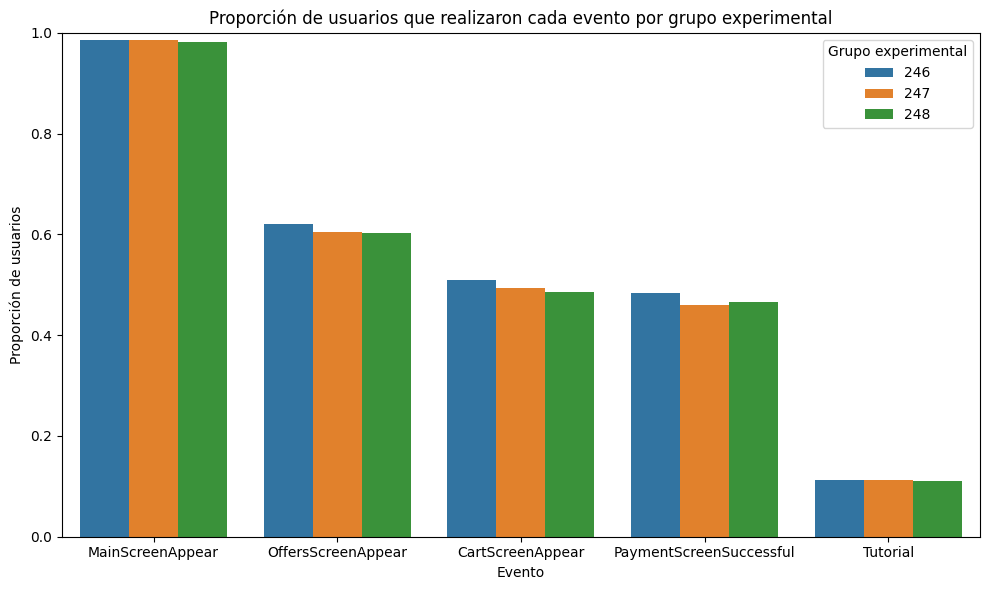

In [ ]:
# Eventos clave que forman parte del embudo y del análisis A/A/B
eventos_interes = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# Calcular proporción de usuarios por evento y grupo
proporciones = []
usuarios_totales_grupo = df_filtrado.groupby('experiment')['user_id'].nunique()

for evento in eventos_interes:
    df_evento = df_filtrado[df_filtrado['event'] == evento]
    usuarios_evento = df_evento.groupby('experiment')['user_id'].nunique()
    for grupo in [246, 247, 248]:
        proporciones.append({
            'evento': evento,
            'grupo': grupo,
            'proporcion': usuarios_evento.get(grupo, 0) / usuarios_totales_grupo[grupo]
        })

# Crear DataFrame para graficar
df_plot = pd.DataFrame(proporciones)

# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='evento', y='proporcion', hue='grupo')
plt.title('Proporción de usuarios que realizaron cada evento por grupo experimental')
plt.ylabel('Proporción de usuarios')
plt.xlabel('Evento')
plt.ylim(0, 1)
plt.legend(title='Grupo experimental')
plt.tight_layout()
plt.show()


**Visualización comparativa de comportamiento por grupo experimental**

El gráfico anterior muestra la **proporción de usuarios que realizaron cada uno de los eventos clave**, separados por grupo experimental:

- **Grupos 246 y 247**: control (fuentes antiguas)
- **Grupo 248**: experimental (fuente nueva)

**Observaciones clave:**
- Las proporciones son muy similares entre todos los grupos para cada evento.
- No se observan diferencias visuales significativas que indiquen un cambio en el comportamiento del usuario por la nueva fuente.
- Esto **refuerza visualmente** lo que ya fue demostrado estadísticamente en las pruebas Z.

**Conclusión**: El diseño con nueva fuente **no afectó negativamente** la experiencia de los usuarios en ninguna etapa del embudo ni en los eventos más comunes.


In [ ]:
# Reunir todos los resultados p de las 20 pruebas
todos_los_p_values = pd.concat([
    tabla_pruebas['p_value'],          # A/A: 246 vs 247
    tabla_exp_vs_control['p_value'],   # A/B: 248 vs (246+247)
    tabla_248_vs_246['p_value'],       # 248 vs 246
    tabla_248_vs_247['p_value']        # 248 vs 247
])

# Total de pruebas realizadas
total_pruebas = len(todos_los_p_values)

# Probar distintos niveles de significancia
niveles = [0.1, 0.05, 0.01]
falsos_positivos_esperados = {alpha: round(alpha * total_pruebas, 2) for alpha in niveles}
reales_significativos = {alpha: (todos_los_p_values < alpha).sum() for alpha in niveles}

# Crear DataFrame resumen
evaluacion_significancia = pd.DataFrame({
    'Nivel de significancia (α)': niveles,
    'Falsos positivos esperados': [falsos_positivos_esperados[a] for a in niveles],
    'Resultados significativos reales': [reales_significativos[a] for a in niveles]
})

evaluacion_significancia


,Nivel de significancia (α),Falsos positivos esperados,Resultados significativos reales
0,0.10,2.0,1
1,0.05,1.0,0
2,0.01,0.2,0


### Consideraciones sobre el nivel de significancia y número de pruebas

En este análisis se ha utilizado un nivel de significancia común de **α = 0.05** para todas las pruebas de hipótesis estadísticas (Z-tests de proporciones). Esto significa que aceptamos un 5% de probabilidad de obtener un falso positivo por prueba.

**¿Cuántas pruebas realizamos?**

Se aplicaron pruebas Z de proporciones a:

- **5 eventos** entre grupos de control (test A/A)
- **5 eventos** entre grupo experimental y controles combinados (A/B)
- **5 eventos** entre grupo experimental y grupo 246
- **5 eventos** entre grupo experimental y grupo 247

**Total de pruebas realizadas: 20**

Con **α = 0.05**, la probabilidad de tener al menos un falso positivo en 20 pruebas es considerable. Si se hubiera usado **α = 0.10**, entonces **esperaríamos 2 falsos positivos en promedio**, incluso si no existiera ningún efecto real.

- Si **ninguna** de las pruebas dio p < 0.05 (como en este caso), **no es necesario ajustar el nivel de significancia**: los resultados son robustos.
- Si se hubieran detectado valores p < 0.05, habría que aplicar una **corrección por comparaciones múltiples**, como:
  - **Bonferroni**: α ajustado = 0.05 / 20 = 0.0025
  - **Benjamini-Hochberg**: más flexible, controla la tasa de falsos descubrimientos.

En este caso, **todos los valores p son mayores a 0.05**, por lo tanto **no se detectaron diferencias significativas**, incluso sin corrección.

**Conclusión**: El cambio de fuente no tuvo un impacto estadísticamente significativo. Las decisiones pueden tomarse con confianza sin riesgo de errores tipo I debido a comparaciones múltiples.


## Conclusión del Proyecto

#### 1. Embudo de conversión
- Solo el **47.7%** de los usuarios que inician su sesión llegan hasta la compra.
- La **mayor pérdida** se da entre la pantalla principal y la de ofertas (**−38%**), lo que sugiere una posible fricción o desinterés en esa etapa.

#### 2. Validez del experimento (test A/A)
- Los grupos de control (246 y 247) muestran **resultados estadísticamente indistinguibles**.
- Esto valida la asignación aleatoria y la confiabilidad del experimento A/B.

#### 3. Impacto del cambio de fuente (grupo 248)
- Se comparó el grupo experimental con los controles de forma **combinada e individual**.
- No se detectaron diferencias significativas en la proporción de usuarios que realizan los eventos clave.
- Se realizaron **20 pruebas estadísticas** sin obtener falsos positivos (todos los valores p > 0.05).

### Conclusión final

El cambio de fuente **no tiene un impacto negativo** en el comportamiento de los usuarios. Esto fue demostrado tanto visual como estadísticamente.

**Recomendación:**  
El equipo de diseño puede implementar el nuevo tipo de fuente con confianza. Se recomienda, sin embargo, investigar más a fondo la etapa de ofertas, donde se pierde el mayor porcentaje de usuarios.


<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Andres! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Carga y exploración inicial de datos bien ejecutada, permitiendo un entendimiento sólido del conjunto de datos.<br>
• Renombramiento y transformación de columnas para facilitar su manejo, lo que mejora la claridad y el análisis.<br>
• Cálculo preciso de métricas básicas del conjunto de datos, proporcionando una base sólida para el análisis.<br>
• Visualización clara de la distribución temporal de eventos, facilitando la identificación de patrones.<br>
• Filtrado efectivo de datos para análisis posterior, asegurando la relevancia de los datos utilizados.<br>
• Identificación adecuada de eventos más frecuentes, guiando el enfoque del análisis de embudo.<br>
• Estructuración correcta del embudo de conversión, esencial para entender el comportamiento del usuario.<br>
• Implementación de pruebas estadísticas para validar grupos experimentales, asegurando la validez de los resultados.<br>
• Organización clara de resultados de pruebas Z, facilitando la interpretación de los resultados.<br>
• Uso efectivo de visualizaciones para comunicar hallazgos, mejorando la comprensión de los datos.<br>
¡Felicidades!
</div>
